In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import copy
from glob import glob
import gc
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from timeit import default_timer as timer

from utils import get_config_from_json
from backbone.unet3d import UNet_ODT


import numpy as np
from scipy.ndimage import distance_transform_edt
import pandas as pd
from skimage.morphology import skeletonize
import napari
from scipy.spatial import distance_matrix
from skimage.draw import line_nd
import skimage.io as skio

from matplotlib import pyplot as plt
%matplotlib inline

# Load AmiraGlow colormap
from scipy import io
cm_mat = io.loadmat('./weights/AmiraHotmap.mat')
from matplotlib.colors import ListedColormap
amiraglow = ListedColormap(cm_mat['AmiraHot'])

colormap_array = np.concatenate((cm_mat['AmiraHot'], np.ones((256, 1))), axis=1)
cm_napari_amiraglow = napari.utils.Colormap(
        colors=colormap_array, display_name='AmiraGlow')

/home/oct3090/anaconda3/envs/dev-reck-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0'

model = UNet_ODT()
model_path = './weights/model_weights_best.pth'
model.load_state_dict(torch.load(model_path))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_totaltrainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, pytorch_totaltrainable_params)

model = model.to(device)
model.eval()

config = get_config_from_json('config_unet.json')
config

7182401 7182401


{'model_name': 'odt3d_vt_unet_S2_skelHinge_valHinge_bz256_multibreaks',
 'dataset': 'ODT',
 'CLS_branch': False,
 'SEG_branch': False,
 'EDT_branch': True,
 'epochs': 200,
 'save_period': 40,
 'learning_rate': 0.001,
 'sample_per_batch': 20,
 'batch_size': 224,
 'batch_size_val': 256,
 'patch_size': [32, 32, 32],
 'ratio': 0.5,
 'ft_num': 8,
 'bgmean_weight': 1.0,
 'skelloss_weight': 1,
 'clsloss_weight': 1}

## Inference

In [3]:
# Load ODT inference samples.
image_fused_patch = np.load('./dataset/odt_testing.npy')

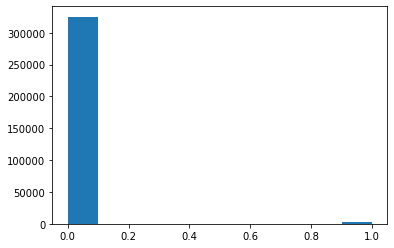

In [15]:
torch.manual_seed(20221027)
with torch.no_grad():
    X_input = torch.from_numpy(image_fused_patch[:, 2:3]).to(device)

    with torch.cuda.amp.autocast():
        output_skel = model(X_input)
        #loss_skel = loss_fn_skel(output_skel, X_GT_input, roi_mask_input)
    output_skel = output_skel.detach().cpu().numpy()
    
idx_patch = -1
plt.hist(output_skel.flatten());

IDX-000: 


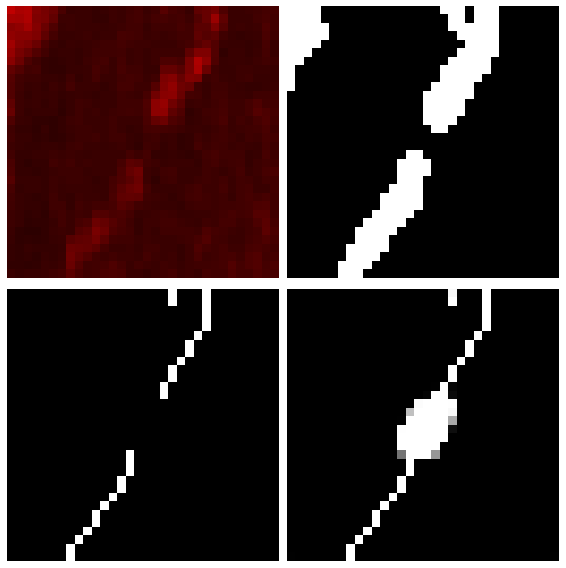

In [16]:
idx_patch += 1
# 3D pred. mk2 for skeleton and mk3 for skelmap vis..
pred_mk2 = np.max(np.array(
    [image_fused_patch[idx_patch, 2],
     output_skel[idx_patch, 0].astype(np.float32)>0.5
    ]), axis=0)
pred_mk2 = output_skel[idx_patch, 0].astype(np.float32)>0.5
pred_mk2_skel = skeletonize(pred_mk2)
# Only show difference between pred and input.
pred_mk2_skel_only = pred_mk2_skel - 255*image_fused_patch[idx_patch, 2]
pred_mk2_skel_only[pred_mk2_skel_only > 0] = 255
pred_mk2_skel_only[pred_mk2_skel_only <= 0] = 0

# Prediction only for missing region.
pred_mk3_mask = output_skel[idx_patch, 0].astype(np.float32)>0.5
pred_mk3_maskonly = np.logical_and(
    pred_mk3_mask, np.logical_not(image_fused_patch[idx_patch, 2].astype(np.bool8)))
pred_mk3 = output_skel[idx_patch, 0] * pred_mk3_maskonly
pred_mk3_skel = skeletonize(pred_mk3)


plt.figure(figsize=(8,8))
plt.subplot(221)
image_patch_vis = np.max(image_fused_patch[idx_patch, 0], axis=0)
plt.imshow(image_patch_vis, vmin=0, vmax=1, cmap='hot')
plt.axis('off')

plt.subplot(222)
plt.imshow(np.max(image_fused_patch[idx_patch, 1], axis=0), cmap='gray')
plt.axis('off')

plt.subplot(223)
plt.imshow(np.max(image_fused_patch[idx_patch, 2], axis=0), cmap='gray')
plt.axis('off')

plt.subplot(224)
plt.imshow(np.max(output_skel[idx_patch, 0], axis=0), vmin=0, vmax=1, cmap='gray')
plt.axis('off')


plt.tight_layout()

print('IDX-{:03d}: '.format(idx_patch))

####  napari visualization in 3D

In [20]:
pr = 31
# (z,y,x): z=0 is front;
#          z
#         /
# (0,0,0)/__x
#        |
#        y

bounding_box_all = np.array(
    [
        [0, 0, 0],
        [pr, 0, 0],
        [0, pr, 0],
        [pr, pr, 0], # Block bottom-back-left point.
        [0, 0, pr],
        [pr, 0, pr],
        [0, pr, pr],
        [pr, pr, pr],
    ]
)

edge_all = np.array([
    # Right
    [[0, 0, pr],
     [0, pr, pr],
     [pr, pr, pr],
     [pr, 0, pr]],
    
    # front
    [[0, 0, 0],
     [0, 0, pr],
     [0, pr, pr],
     [0, pr, 0]],
    
    # up
    [[0, 0, 0],
     [pr, 0, 0],
     [pr, 0, pr],
     [0, 0, pr]],
    
    # left
    [[0, 0, 0],
     [pr, 0, 0],
     [pr, pr, 0],
     [0, pr, 0]],

    # back
    [[pr, 0, 0],
     [pr, 0, pr],
     [pr, pr, pr],
     [pr, pr, 0]],

    # bottom
    [[0, pr, 0],
     [0, pr, pr],
     [pr, pr, pr],
     [pr, pr, 0]],
])

viewangle_dict = {}


if 'viewer_vt_test' in locals() or 'viewer_vt_test' in globals():
    viewer_vt_test.close()

viewer_vt_test = napari.Viewer(ndisplay=3)

viewer_vt_test.add_labels(
    data=pred_mk2_skel_only.astype(np.uint8), color={255: 'cyan'},
    opacity=1.0,  name='skel_pred')

viewer_vt_test.add_labels(
    data=image_fused_patch[idx_patch, 2].astype(np.uint8),
    color={1: 'lightgray'}, opacity=1., name='skel_input')

viewer_vt_test.add_image(
    data=pred_mk3,
    colormap='jet', opacity=1., blending='additive', visible=False, name='pred_mask')

viewer_vt_test.add_labels(
    data=image_fused_patch[idx_patch, 1].astype(np.uint8),
    color={1: 'lightcoral'}, opacity=1., blending='additive', visible=False, name='mask_input')

viewer_vt_test.add_image(
    data=image_fused_patch[idx_patch, 0],
    colormap=cm_napari_amiraglow,
    contrast_limits=[1500/65535, 25000/65535],
    opacity=0.7,
    visible=False)

viewer_vt_test.add_points(
    data=[[0,0,0]],
    symbol='disc',
    size=1.5,
    opacity=1,
    face_color='red',
    name='Origin',
    visible=False
    )

if idx_patch in viewangle_dict:
    viewer_vt_test.camera.angles = viewangle_dict[idx_patch][0]
    bounding_box = np.delete(bounding_box_all, obj=viewangle_dict[idx_patch][1], axis=0)
    edge = np.delete(edge_all, obj=viewangle_dict[idx_patch][2], axis=0)
else:
    bounding_box = bounding_box_all[[0,1,2,4,5,6,7]]
    edge = edge_all

    
bounding_box_layer = viewer_vt_test.add_points(
    data=bounding_box, symbol='square', size=1.1,
    opacity=1.0, face_color='white', name='bounding box') # cornflowerblue

bounding_box_layer = viewer_vt_test.add_shapes(
    data=edge, edge_width=0.1,
    opacity=0.5, edge_color='lime', face_color='transparent', name='bounding edge')


In [ ]:
# Boundingbox part.
viewangle_dict = {
    1111: [[-1.23, 10.15, 80.48], 3, []],
    0: [[  2.75, -26.38,  81.04], -1, [0,-2]],
}

print(np.around(np.array(viewer_vt_test.camera.angles), 2))